# PFAS Cost-Risk Analysis

## Overview
This notebook analyzes the cost-effectiveness of different PFAS treatment scenarios using UCMR5 data.

## Starting Dataset
- Source: `system_max_with_population` from `Pfas_ucmr5_analysis.ipynb`
- Systems: 9,771 water systems with population data
- Key columns: PWSID, PFOA, PFOS, POPULATION_SERVED_COUNT, population_bin

## Objectives
1. Estimate treatment costs for varying regulatory thresholds (4, 8, 12, 20, 40 ng/L)
2. Calculate risk reduction (ng×person/day) for each scenario
3. Determine the cost-effectiveness of different treatment targets
4. Visualize trade-offs between costs and public health benefits

In [1]:
# Load necessary Python Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Read the data from system_max_with_population file
df = pd.read_csv('system_max_with_population_clean.csv')

In [3]:
df.head()

,PWSID,PFOA,PFOS,exceeds_threshold(0.004*0.8),POPULATION_SERVED_COUNT,population_bin
0,AK2110342,0.0,0.0,False,38526.0,"10,001 - 50,000"
1,AK2110601,0.0,0.0,False,10947.0,"10,001 - 50,000"
2,AK2120232,0.0,0.0,False,8937.0,"3,301 - 10,000"
3,AK2130075,0.0,0.0,False,9448.0,"3,301 - 10,000"
4,AK2210605,0.0,0.0,False,794.0,"501 - 1,000"


In [4]:
df.tail()

,PWSID,PFOA,PFOS,exceeds_threshold(0.004*0.8),POPULATION_SERVED_COUNT,population_bin
9766,WY5601569,0.0,0.0,False,580.0,"501 - 1,000"
9767,WY5680074,0.0,0.0,False,4300.0,"3,301 - 10,000"
9768,WY5680085,0.0,0.0,False,7675.0,"3,301 - 10,000"
9769,WY5680095,0.0,0.0,False,4514.0,"3,301 - 10,000"
9770,WY5680122,0.0,0.0,False,5500.0,"3,301 - 10,000"


In [5]:
df.sample(10)

,PWSID,PFOA,PFOS,exceeds_threshold(0.004*0.8),POPULATION_SERVED_COUNT,population_bin
4770,MO5010458,0.0000,0.0000,False,15442.0,"10,001 - 50,000"
7498,SC4620003,0.0000,0.0000,False,18273.0,"10,001 - 50,000"
3022,IN5236005,0.0000,0.0000,False,19695.0,"10,001 - 50,000"
7820,TX0010001,0.0000,0.0000,False,31272.0,"10,001 - 50,000"
7731,TN0000546,0.0173,0.0259,True,7388.0,"3,301 - 10,000"
6404,OH4800603,0.0000,0.0000,False,14286.0,"10,001 - 50,000"
6613,OK1021301,0.0000,0.0000,False,3800.0,"3,301 - 10,000"
8421,TX1013054,0.0000,0.0000,False,6129.0,"3,301 - 10,000"
2711,IL0970850,0.0000,0.0000,False,19759.0,"10,001 - 50,000"
7445,SC3220003,0.0044,0.0062,True,47838.0,"10,001 - 50,000"


In [6]:
df.query('`exceeds_threshold(0.004*0.8)` == True') 

,PWSID,PFOA,PFOS,exceeds_threshold(0.004*0.8),POPULATION_SERVED_COUNT,population_bin
5,AK2210906,0.0091,0.0000,True,221351.0,"100,001 - 1,000,000"
21,AK2310730,0.0054,0.0000,True,78324.0,"50,001 - 100,000"
22,AK2310900,0.0064,0.0000,True,27000.0,"10,001 - 50,000"
24,AK2320078,0.0000,0.0463,True,4900.0,"3,301 - 10,000"
29,AL0000013,0.0161,0.0202,True,8670.0,"3,301 - 10,000"
...,...,...,...,...,...,...
9734,WV3305405,0.0132,0.0000,True,5674.0,"3,301 - 10,000"
9735,WV3305407,0.0465,0.0000,True,34251.0,"10,001 - 50,000"
9736,WV3305410,0.0058,0.0000,True,7252.0,"3,301 - 10,000"
9738,WV3305412,0.0320,0.0000,True,3469.0,"3,301 - 10,000"


In [7]:
total_systems = len(df)
exceeding_systems = len(df.query('`exceeds_threshold(0.004*0.8)` == True'))
non_exceeding_systems = total_systems - exceeding_systems
percent_exceed = (exceeding_systems / total_systems) * 100

print("=== Exceedance Summary (0.0032 µg/L threshold) ===")
print(f"Total number of systems: {total_systems:,}")
print(f"Systems exceeding threshold: {exceeding_systems:,}")
print(f"Systems NOT exceeding threshold: {non_exceeding_systems:,}")
print(f"Percentage exceeding: {percent_exceed:.2f}%")


=== Exceedance Summary (0.0032 µg/L threshold) ===
Total number of systems: 9,771
Systems exceeding threshold: 1,611
Systems NOT exceeding threshold: 8,160
Percentage exceeding: 16.49%


### PFAS Threshold Exceedance (4–40 ng/L)

Our dataset reports PFOA and PFOS in µg/L, we convert thresholds from ng/L → µg/L:

- 4 ng/L → 0.004 µg/L  
- 8 ng/L → 0.008 µg/L  
- 12 ng/L → 0.012 µg/L  
- 20 ng/L → 0.020 µg/L  
- 40 ng/L → 0.040 µg/L  


For each threshold, we create a column (`exceeds_4`, `exceeds_8`, …) that is True if `PFOA` or `PFOS`  exceeds the converted value.

These columns define which systems would require treatment under different regulatory scenarios.


In [8]:
# create a new column in the df total_pfas adding both the pfas.
df['total_pfas'] = df['PFOA'] + df['PFOS']

In [9]:
thresholds_ng = [4, 8, 12, 20, 40]

for t in thresholds_ng:
    col_name = f"exceeds_{t}"
    threshold_ug = t / 1000   # convert ng/L → µg/L
    df[col_name] = (df['PFOA'] > threshold_ug) | (df['PFOS'] > threshold_ug) #initially i did total pfas > threshold_ug, but now either one

In [10]:
df[['total_pfas', 'PFOA', 'PFOS', 'exceeds_4', 'exceeds_8', 'exceeds_12', 'exceeds_20', 'exceeds_40']].sample(20)

,total_pfas,PFOA,PFOS,exceeds_4,exceeds_8,exceeds_12,exceeds_20,exceeds_40
563,0.000,0.0,0.000,False,False,False,False,False
3516,0.000,0.0,0.000,False,False,False,False,False
5433,0.000,0.0,0.000,False,False,False,False,False
383,0.000,0.0,0.000,False,False,False,False,False
7362,0.000,0.0,0.000,False,False,False,False,False
16,0.000,0.0,0.000,False,False,False,False,False
6774,0.000,0.0,0.000,False,False,False,False,False
449,0.000,0.0,0.000,False,False,False,False,False
2392,0.000,0.0,0.000,False,False,False,False,False
410,0.000,0.0,0.000,False,False,False,False,False


In [11]:
print("=== Number of Systems Exceeding Each Threshold ===")
for t in thresholds_ng:
    col = f"exceeds_{t}"
    count = df[col].sum()
    percent = (count / len(df)) * 100
    print(f"{t} ng/L: {count:,} systems ({percent:.2f}%)")

=== Number of Systems Exceeding Each Threshold ===
4 ng/L: 1,583 systems (16.20%)
8 ng/L: 742 systems (7.59%)
12 ng/L: 413 systems (4.23%)
20 ng/L: 177 systems (1.81%)
40 ng/L: 42 systems (0.43%)


### Risk Reduction Based on Drinking Water Intake (ng/day)

The EPA assumes the average adult consumes 2 liters per day of tap water.  
Therefore, PFAS exposure per system is estimated as:

$$
\text{ng/day total} = (\text{PFOA} + \text{PFOS})_{\mu g/L} 
\times 2\ \text{L/day/person} 
\times \text{Population Served} 
\times 1000\ \text{ng}/\mu g
$$


This value represents the total PFAS exposure per day for all people served by that system.


In [12]:
# Total exposure per system (ng/day)
df['ng/day_total'] = (df['total_pfas']* #pfas is in ug
                     2000 * #ug/day per person for 2 L/day
                     df['POPULATION_SERVED_COUNT']) 


In [13]:
df.sample(10)

,PWSID,PFOA,PFOS,exceeds_threshold(0.004*0.8),POPULATION_SERVED_COUNT,population_bin,total_pfas,exceeds_4,exceeds_8,exceeds_12,exceeds_20,exceeds_40,ng/day_total
6196,NY5821130,0.0000,0.0000,False,5800.0,"3,301 - 10,000",0.0000,False,False,False,False,False,0.0
3942,MA4089000,0.0000,0.0000,False,8027.0,"3,301 - 10,000",0.0000,False,False,False,False,False,0.0
5381,ND0200958,0.0000,0.0000,False,6585.0,"3,301 - 10,000",0.0000,False,False,False,False,False,0.0
1366,CO0121455,0.0000,0.0000,False,12760.0,"10,001 - 50,000",0.0000,False,False,False,False,False,0.0
6575,OK1010828,0.0000,0.0000,False,8883.0,"3,301 - 10,000",0.0000,False,False,False,False,False,0.0
685,CA1010019,0.0000,0.0000,False,13540.0,"10,001 - 50,000",0.0000,False,False,False,False,False,0.0
820,CA1910101,0.0099,0.0230,True,25000.0,"10,001 - 50,000",0.0329,True,True,True,True,False,1645000.0
3457,KY1090060,0.0000,0.0000,False,24874.0,"10,001 - 50,000",0.0000,False,False,False,False,False,0.0
9594,WI4690402,0.0000,0.0043,True,6062.0,"3,301 - 10,000",0.0043,True,False,False,False,False,52133.2
3444,KY1020891,0.0000,0.0000,False,12623.0,"10,001 - 50,000",0.0000,False,False,False,False,False,0.0


In [14]:
# sum the total pfas exposure(ng/day total) across all systems that exceed each regulatory threshold
pfas_exposure_by_threshold = {}

for t in thresholds_ng:
    column = f"exceeds_{t}"
    ng_sum = (df['ng/day_total'] * df[column]).sum()
    pfas_exposure_by_threshold[t] = round(float(ng_sum), 2)
    
pfas_exposure_by_threshold

{4: 2699756612.8,
 8: 2122924364.6,
 12: 1626517469.8,
 20: 1082211578.4,
 40: 328664998.2}

In [15]:
# sum the population served for all water systems (PWS) that exceed each PFAS regulatory threshold
population_by_threshold = {}

for t in thresholds_ng:
    cols = f"exceeds_{t}"
    population_sum = df.loc[df[cols],'POPULATION_SERVED_COUNT'].sum()
    population_by_threshold[t] = int(population_sum)
    
population_by_threshold

{4: 77430596, 8: 39519447, 12: 22959922, 20: 11390515, 40: 2144111}

### Average PFAS Exposure Reduction (ng/day/person)

To understand how much PFAS exposure the average individual would avoid under each regulatory threshold, we divide the total PFAS exposure (ng/day) for all systems above the threshold by the total population served by those systems:

$$
\text{ng/day/person}_T
=
\frac{\text{ng/day total}_T}{\text{Population}_T}
$$


In [16]:
# compute the average PFAS exposure per person (ng/day/person) for each threshold
ng_day_per_person = {}

for t in thresholds_ng:
    total_ng = pfas_exposure_by_threshold[t]         # total ng/day
    total_pop = population_by_threshold[t]           # total population
    
  
    value = (total_ng / total_pop) if total_pop > 0 else 0
    ng_day_per_person[t] = round(value, 2)

ng_day_per_person

{4: 34.87, 8: 53.72, 12: 70.84, 20: 95.01, 40: 153.29}

In [17]:
# just fixing a typo mistake
df['population_bin'] = df['population_bin'].replace({'25 to 100': '25 - 100'})

In [18]:
# mapping population bin with facility annualized cost column of Table 4 in the Corona memo

popbin_cost_map = {
    '25 - 100': 0.07,
    '101 - 500': 0.12,
    '501 - 1,000': 0.17,
    '1,001 - 3,300': 0.25,
    '3,301 - 10,000': 0.40,
    '10,001 - 50,000': 0.76,
    '50,001 - 100,000': 1.29,
    '100,001 - 1,000,000': 2.33,
    '> 1,000,000': 4.76
}

df['annualized_cost($M)'] = df['population_bin'].map(popbin_cost_map)
df[['population_bin', 'annualized_cost($M)']].head(10)

,population_bin,annualized_cost($M)
0,"10,001 - 50,000",0.76
1,"10,001 - 50,000",0.76
2,"3,301 - 10,000",0.40
3,"3,301 - 10,000",0.40
4,"501 - 1,000",0.17
5,"100,001 - 1,000,000",2.33
6,"10,001 - 50,000",0.76
7,"10,001 - 50,000",0.76
8,25 - 100,0.07
9,"10,001 - 50,000",0.76


In [19]:
# sum up  total national treatment costs for each of 4, 8, 12, 20, 40 scenarios
national_treatment_costs = {}

for t in thresholds_ng:
    col = f"exceeds_{t}"
    # For each system: cost * 1 if it exceeds the threshold, else cost * 0.
    # Summing these values gives the total national treatment cost for that threshold.
    total_cost_M = (df['annualized_cost($M)'] * df[col]).sum()  
    national_treatment_costs[t] = round(float(total_cost_M), 2)

national_treatment_costs

{4: 1334.92, 8: 644.97, 12: 364.64, 20: 169.35, 40: 37.7}

### National Annualized Cost Results

Using the population-bin specific annualized cost values from the Corona (Black & Veatch)
technical memo, the total national annualized cost for each PFAS regulatory scenario is:

| Threshold (ng/L) | National Cost ($M) |
|------------------|--------------------|
| 4 ng/L           | 1334.29            |
| 8 ng/L           | 644.69             |
| 12 ng/L          | 364.57             |
| 20 ng/L          | 169.28             |
| 40 ng/L          | 37.63              |


In [20]:
rows = []

for pop, cost in popbin_cost_map.items():

    row = {"population_bin": pop, "annualized_cost_per_facility ($M)": cost}

    # filter only systems in this bin
    bin_df = df[df["population_bin"] == pop]


    for t in thresholds_ng:
        col = f"exceeds_{t}"  
        num = bin_df[col].sum()
        total = num * cost

        row[f"num_{t}"] = num
        row[f"total_cost_{t} ($M)"] = round(total, 2)

    rows.append(row)

comparison_table = pd.DataFrame(rows)
comparison_table


,population_bin,annualized_cost_per_facility ($M),num_4,total_cost_4 ($M),num_8,total_cost_8 ($M),num_12,total_cost_12 ($M),num_20,total_cost_20 ($M),num_40,total_cost_40 ($M)
0,25 - 100,0.07,9,0.63,4,0.28,1,0.07,1,0.07,1,0.07
1,101 - 500,0.12,11,1.32,7,0.84,4,0.48,2,0.24,2,0.24
2,"501 - 1,000",0.17,13,2.21,4,0.68,3,0.51,1,0.17,0,0.00
3,"1,001 - 3,300",0.25,49,12.25,20,5.00,11,2.75,7,1.75,1,0.25
4,"3,301 - 10,000",0.40,509,203.60,244,97.60,136,54.40,46,18.40,12,4.80
5,"10,001 - 50,000",0.76,672,510.72,298,226.48,161,122.36,71,53.96,16,12.16
6,"50,001 - 100,000",1.29,157,202.53,77,99.33,45,58.05,21,27.09,3,3.87
7,"100,001 - 1,000,000",2.33,154,358.82,84,195.72,50,116.50,27,62.91,7,16.31
8,"> 1,000,000",4.76,9,42.84,4,19.04,2,9.52,1,4.76,0,0.00


### COMPARING CORONA AND UCMR5

To align the UCMR5-based results with the Corona methodology, systems exceeding 80% of the 4 ng/L threshold (3.2 ng/L) for either PFOA or PFOS were identified in UCMR5. These counts were compared against the total number of impacted entry points reported in Corona Table 3 (GW + SW) for each population bin.


In [21]:
corona_table3 = {
    '25 - 100': 1800,
    '101 - 500': 2142,
    '501 - 1,000': 627,
    '1,001 - 3,300': 938,
    '3,301 - 10,000': 864,
    '10,001 - 50,000': 1091,
    '50,001 - 100,000': 326,
    '100,001 - 1,000,000': 458,
    '> 1,000,000': 67
}


In [22]:
rows = []

for pop in popbin_cost_map.keys():

    bin_df = df[df["population_bin"] == pop]

    # UCMR5 systems exceeding 4 × 0.8 
    ucmr5_count = bin_df["exceeds_threshold(0.004*0.8)"].sum()


    # Corona national entry points
    corona_count = corona_table3[pop]

    percent_of_corona = ucmr5_count / corona_count

    rows.append({
        "population_bin": pop,
        "ucmr5_4x0.8": ucmr5_count,
        "corona_gw_sw": corona_count,
        "percent_of_corona": round(percent_of_corona, 3)
    })

corona_comparison = pd.DataFrame(rows)
corona_comparison


,population_bin,ucmr5_4x0.8,corona_gw_sw,percent_of_corona
0,25 - 100,9,1800,0.005
1,101 - 500,12,2142,0.006
2,"501 - 1,000",13,627,0.021
3,"1,001 - 3,300",50,938,0.053
4,"3,301 - 10,000",519,864,0.601
5,"10,001 - 50,000",684,1091,0.627
6,"50,001 - 100,000",159,326,0.488
7,"100,001 - 1,000,000",156,458,0.341
8,"> 1,000,000",9,67,0.134


### Scaling UCMR5 Results to All-U.S. Systems and National Cost Estimation
UCMR5 includes only a subset of U.S. water systems, exceedance counts were scaled using Corona (Black & Veatch) population-bin ratios to estimate the total number of systems nationwide exceeding PFAS thresholds (4, 8, 12, 20, and 40 ng/L).

In [23]:
comparison_scaled = comparison_table.merge(
    corona_comparison[["population_bin","percent_of_corona"]],
    on = "population_bin",
    how = "left"
)

In [24]:
for t in thresholds_ng:
    comparison_scaled[f"proj_num_{t}"] = (
        comparison_scaled[f"num_{t}"] /
        comparison_scaled["percent_of_corona"]
    ).round(0)

In [25]:
for t in thresholds_ng:
    comparison_scaled[f"proj_cost_{t} ($M)"] = (
        comparison_scaled[f"proj_num_{t}"] *
        comparison_scaled["annualized_cost_per_facility ($M)"]
    ).round(2)
comparison_scaled

,population_bin,annualized_cost_per_facility ($M),num_4,total_cost_4 ($M),num_8,total_cost_8 ($M),num_12,total_cost_12 ($M),num_20,total_cost_20 ($M),...,proj_num_4,proj_num_8,proj_num_12,proj_num_20,proj_num_40,proj_cost_4 ($M),proj_cost_8 ($M),proj_cost_12 ($M),proj_cost_20 ($M),proj_cost_40 ($M)
0,25 - 100,0.07,9,0.63,4,0.28,1,0.07,1,0.07,...,1800.0,800.0,200.0,200.0,200.0,126.00,56.00,14.00,14.00,14.00
1,101 - 500,0.12,11,1.32,7,0.84,4,0.48,2,0.24,...,1833.0,1167.0,667.0,333.0,333.0,219.96,140.04,80.04,39.96,39.96
2,"501 - 1,000",0.17,13,2.21,4,0.68,3,0.51,1,0.17,...,619.0,190.0,143.0,48.0,0.0,105.23,32.30,24.31,8.16,0.00
3,"1,001 - 3,300",0.25,49,12.25,20,5.00,11,2.75,7,1.75,...,925.0,377.0,208.0,132.0,19.0,231.25,94.25,52.00,33.00,4.75
4,"3,301 - 10,000",0.40,509,203.60,244,97.60,136,54.40,46,18.40,...,847.0,406.0,226.0,77.0,20.0,338.80,162.40,90.40,30.80,8.00
5,"10,001 - 50,000",0.76,672,510.72,298,226.48,161,122.36,71,53.96,...,1072.0,475.0,257.0,113.0,26.0,814.72,361.00,195.32,85.88,19.76
6,"50,001 - 100,000",1.29,157,202.53,77,99.33,45,58.05,21,27.09,...,322.0,158.0,92.0,43.0,6.0,415.38,203.82,118.68,55.47,7.74
7,"100,001 - 1,000,000",2.33,154,358.82,84,195.72,50,116.50,27,62.91,...,452.0,246.0,147.0,79.0,21.0,1053.16,573.18,342.51,184.07,48.93
8,"> 1,000,000",4.76,9,42.84,4,19.04,2,9.52,1,4.76,...,67.0,30.0,15.0,7.0,0.0,318.92,142.80,71.40,33.32,0.00


In [26]:
comparison_scaled[
    ["population_bin",
        'proj_num_4', 'proj_num_8', 'proj_num_12', 'proj_num_20', 'proj_num_40',
        'proj_cost_4 ($M)', 'proj_cost_8 ($M)', 'proj_cost_12 ($M)',
        'proj_cost_20 ($M)', 'proj_cost_40 ($M)'
    ]
]

,population_bin,proj_num_4,proj_num_8,proj_num_12,proj_num_20,proj_num_40,proj_cost_4 ($M),proj_cost_8 ($M),proj_cost_12 ($M),proj_cost_20 ($M),proj_cost_40 ($M)
0,25 - 100,1800.0,800.0,200.0,200.0,200.0,126.00,56.00,14.00,14.00,14.00
1,101 - 500,1833.0,1167.0,667.0,333.0,333.0,219.96,140.04,80.04,39.96,39.96
2,"501 - 1,000",619.0,190.0,143.0,48.0,0.0,105.23,32.30,24.31,8.16,0.00
3,"1,001 - 3,300",925.0,377.0,208.0,132.0,19.0,231.25,94.25,52.00,33.00,4.75
4,"3,301 - 10,000",847.0,406.0,226.0,77.0,20.0,338.80,162.40,90.40,30.80,8.00
5,"10,001 - 50,000",1072.0,475.0,257.0,113.0,26.0,814.72,361.00,195.32,85.88,19.76
6,"50,001 - 100,000",322.0,158.0,92.0,43.0,6.0,415.38,203.82,118.68,55.47,7.74
7,"100,001 - 1,000,000",452.0,246.0,147.0,79.0,21.0,1053.16,573.18,342.51,184.07,48.93
8,"> 1,000,000",67.0,30.0,15.0,7.0,0.0,318.92,142.80,71.40,33.32,0.00


In [27]:
national_costs_all_us = {
    t: round(float(comparison_scaled[f"proj_cost_{t} ($M)"].sum()), 2)
    for t in thresholds_ng
}

# projected cost
national_costs_all_us


{4: 3623.42, 8: 1765.79, 12: 988.66, 20: 484.66, 40: 143.14}

### Cost-Effectiveness of PFAS Treatment ($ per ng of Exposure Reduced)

To evaluate the economic efficiency of each regulatory threshold, we compare the total annual treatment cost to the reduction in PFAS exposure. Based on EPA’s drinking water intake assumption (2 L/day), the cost-effectiveness metric is defined as:

$$
\text{Cost-Effectiveness}_T
=
\frac{\text{Total Annual Cost}_T}
{\text{ng/day total}_T \times 365}
\
$$



In [28]:
cost_effectiveness = {}

for t in thresholds_ng:
    annual_cost = national_treatment_costs[t]   
    ng_per_day_total = pfas_exposure_by_threshold[t]        # ng/day

    ng_per_year = ng_per_day_total * 365 #annual pfas ng/year

    ce = annual_cost / ng_per_year if ng_per_year > 0 else 0

    cost_effectiveness[t] = ce
    
cost_effectiveness

{4: 1.3546832522432596e-09,
 8: 8.32361776686922e-10,
 12: 6.142040999737788e-10,
 20: 4.287263341108289e-10,
 40: 3.1426428673132957e-10}

In [29]:
ce_df = pd.DataFrame.from_dict(cost_effectiveness, orient='index', columns=['Million $ per ng/year'])

ce_df.index.name = 'Threshold (ng/L)'
ce_df.reset_index(inplace=True)

ce_df['$ per ng/year'] = ce_df['Million $ per ng/year'] * 1_000_000

ce_df = ce_df.round({
    'Million $ per ng/year': 12,
    '$ per ng/year': 6
})

ce_df

,Threshold (ng/L),Million $ per ng/year,$ per ng/year
0,4,1.355000e-09,0.001355
1,8,8.320000e-10,0.000832
2,12,6.140000e-10,0.000614
3,20,4.290000e-10,0.000429
4,40,3.140000e-10,0.000314


### Figure 1: Total PFAS Exposure Reduction (ng/day) vs National Annualized Cost

This figure shows the total PFAS exposure avoided each day nationwide under each
regulatory threshold, plotted against the total annualized treatment cost (in million dollars).
Lower thresholds remove more exposure but cost more, while higher thresholds remove less but
cost less.


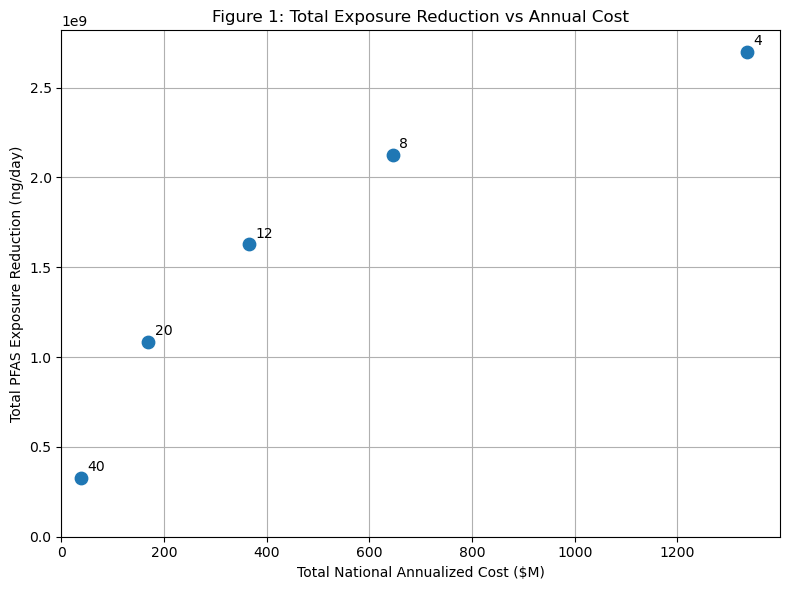

In [30]:
fig1_costs = [national_treatment_costs[t] for t in thresholds_ng]   # $M
fig1_exposure = [pfas_exposure_by_threshold[t] for t in thresholds_ng]  # ng/day

plt.figure(figsize=(8,6))
plt.scatter(fig1_costs, fig1_exposure, s=80)

for t, x, y in zip(thresholds_ng, fig1_costs, fig1_exposure):
    plt.annotate(str(t), (x, y), textcoords="offset points", xytext=(5,5))

plt.xlabel("Total National Annualized Cost ($M)")
plt.ylabel("Total PFAS Exposure Reduction (ng/day)")
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.title("Figure 1: Total Exposure Reduction vs Annual Cost")
plt.grid(True)
plt.tight_layout()
plt.show()


### Figure 1a: Average Exposure Reduction (ng/day/person) vs National Annualized Cost

This figure shows how much PFAS exposure the *average person* avoids each day
under each regulatory threshold, plotted against the national annualized cost.


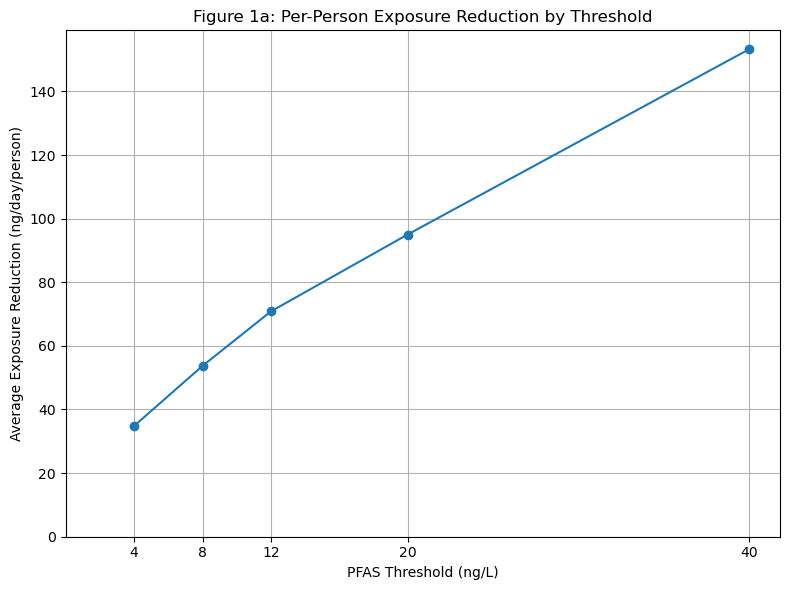

In [31]:
fig1a_costs = fig1_costs   # same $M values
fig1a_exposure = [ng_day_per_person[t] for t in thresholds_ng]  # ng/day/person

plt.figure(figsize=(8,6))
plt.plot(thresholds_ng, fig1a_exposure, marker='o')

plt.xlabel("PFAS Threshold (ng/L)")
plt.ylabel("Average Exposure Reduction (ng/day/person)")
plt.title("Figure 1a: Per-Person Exposure Reduction by Threshold")
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.grid(True)
plt.xticks(thresholds_ng)
plt.tight_layout()
plt.show()


### Figure 2: Cost-Effectiveness of PFAS Treatment by Threshold

Cost-effectiveness is expressed as the dollars (or million dollars) spent per nanogram
of PFAS exposure removed per year. Lower thresholds cost more but remove more exposure.


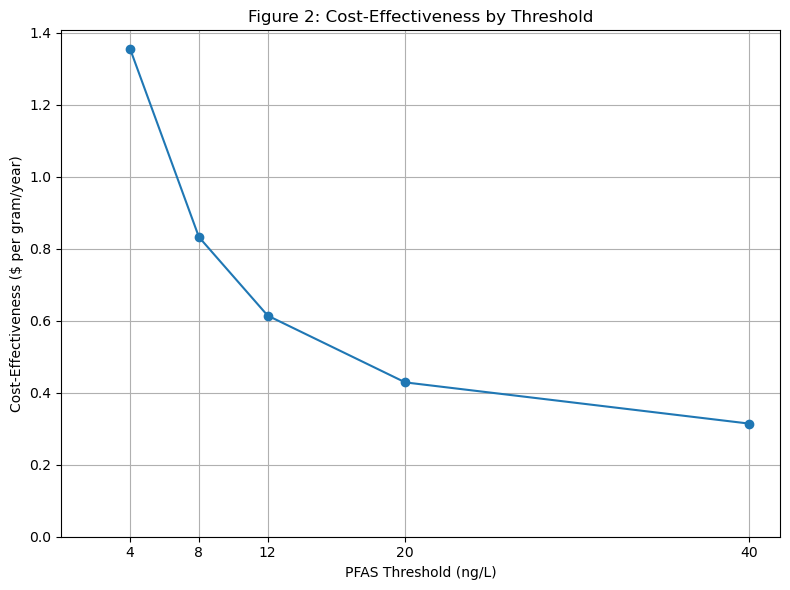

In [32]:
# Convert CE from $ per ng/year → $ per g/year
ce_vals = [cost_effectiveness[t] * 1e9 for t in thresholds_ng]

plt.figure(figsize=(8,6))
plt.plot(thresholds_ng, ce_vals, marker='o')

plt.xlabel("PFAS Threshold (ng/L)")
plt.ylabel("Cost-Effectiveness ($ per gram/year)")
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.title("Figure 2: Cost-Effectiveness by Threshold")
plt.grid(True)
plt.xticks(thresholds_ng)
plt.tight_layout()
plt.show()


In [33]:
overall_exceedance = {}

total_systems = len(df)

for t in thresholds_ng:
    col = f"exceeds_{t}"
    overall_exceedance[t] = df[col].mean() * 100   # % of systems


### Figure 3: Percent of Systems Exceeding PFAS Thresholds

This figure shows (1) the percent of public water systems in each population bin
that exceed each PFAS threshold, and (2) the overall percent of all systems nationwide
that exceed each threshold.


In [34]:
# compute % exceeding per bin
exceed_by_bin = df.groupby("population_bin")[[f"exceeds_{t}" for t in thresholds_ng]].mean() * 100

# reorder bins properly if needed
bin_order = ['25 - 100','101 - 500','501 - 1,000','1,001 - 3,300',
             '3,301 - 10,000','10,001 - 50,000','50,001 - 100,000',
             '100,001 - 1,000,000','> 1,000,000']

exceed_by_bin = exceed_by_bin.reindex(bin_order)


<Figure size 1200x700 with 0 Axes>

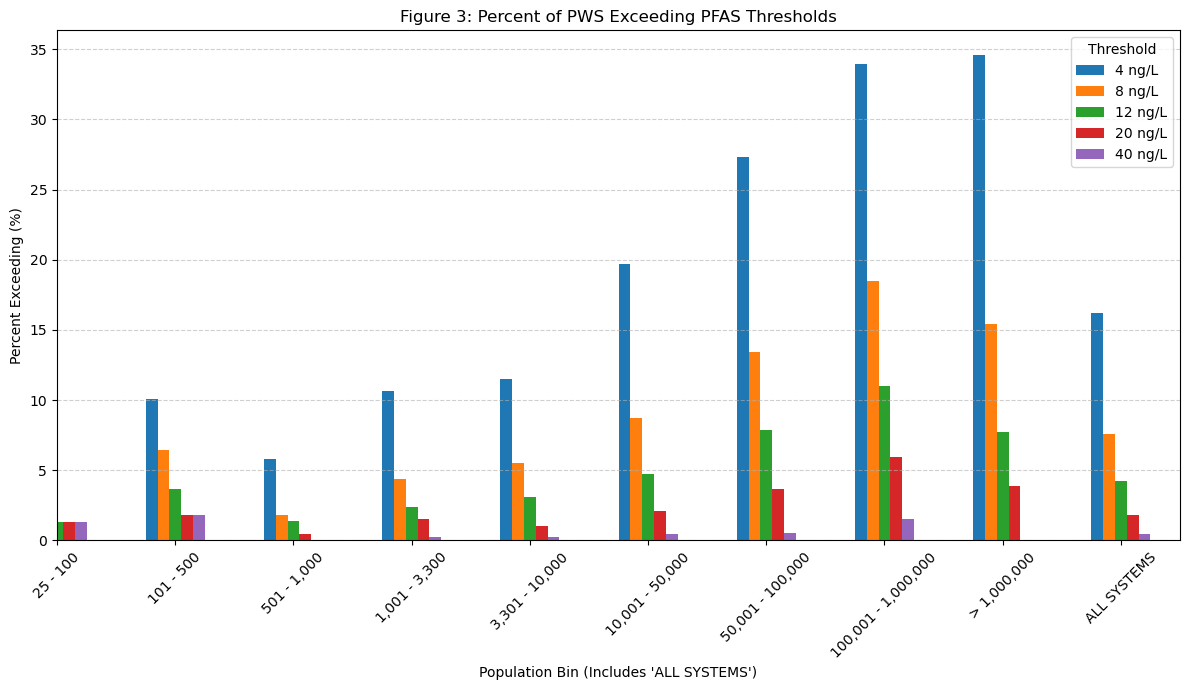

In [35]:
exceed_by_bin.loc["ALL SYSTEMS"] = [overall_exceedance[t] for t in thresholds_ng]

plt.figure(figsize=(12,7))
exceed_by_bin.plot(kind='bar', figsize=(12,7))

plt.title("Figure 3: Percent of PWS Exceeding PFAS Thresholds")
plt.xlabel("Population Bin (Includes 'ALL SYSTEMS')")
plt.ylabel("Percent Exceeding (%)")
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.legend([f"{t} ng/L" for t in thresholds_ng], title="Threshold")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


Power law fit: y = 4.316e+07 * x^0.597


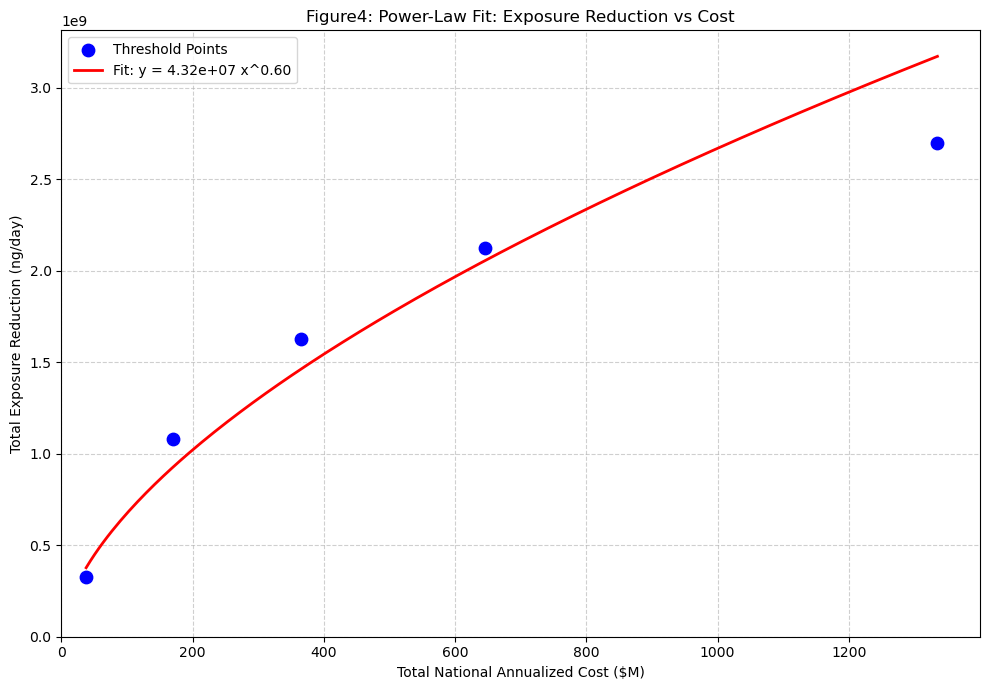

In [36]:
# Gather x (cost) and y (exposure)
x_vals = np.array([national_treatment_costs[t] for t in thresholds_ng])
y_vals = np.array([pfas_exposure_by_threshold[t] for t in thresholds_ng])

# Transform to log space
log_x = np.log(x_vals)
log_y = np.log(y_vals)

# Fit line in log-log space: log(y) = b*log(x) + log(m)
b, log_m = np.polyfit(log_x, log_y, 1)
m = np.exp(log_m)


print(f"Power law fit: y = {m:.3e} * x^{b:.3f}")

# Generate smooth curve
x_fit = np.linspace(x_vals.min(), x_vals.max(), 200)
y_fit = m * x_fit ** b

plt.figure(figsize=(10,7))
plt.scatter(x_vals, y_vals, color='blue', s=80, label="Threshold Points")
plt.plot(x_fit, y_fit, color='red', linewidth=2, label=f"Fit: y = {m:.2e} x^{b:.2f}")

plt.xlabel("Total National Annualized Cost ($M)")
plt.ylabel("Total Exposure Reduction (ng/day)")
plt.title("Figure4: Power-Law Fit: Exposure Reduction vs Cost")
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

### Summary Table of PFAS Regulatory Threshold Impacts

This table summarizes the results for each PFAS regulatory threshold, including:
- Total national annualized treatment cost (in million dollars)
- Total PFAS exposure avoided nationwide (ng/day)
- Average exposure reduction per person (ng/day/person)
- Cost-effectiveness in both million dollars per ng/year and dollars per ng/year

Lower thresholds remove more PFAS exposure but require higher cost, while higher thresholds
require less nationwide treatment cost but yield smaller reductions in population exposure.


In [37]:
summary_rows = []

for t in thresholds_ng:
    cost_M = national_treatment_costs[t]                     # $M
    ng_day_total = pfas_exposure_by_threshold[t]             # ng/day
    ng_day_pp = ng_day_per_person[t]                         # ng/day/person
    
    ce_million = cost_effectiveness[t]                       # million $ per ng/year
    ce_dollar = ce_million * 1_000_000                       # convert to $ per ng/year
    
    summary_rows.append([
        t,
        cost_M,
        ng_day_total,
        ng_day_pp,
        ce_million,
        ce_dollar
    ])

summary_df = pd.DataFrame(summary_rows, columns=[
    "Threshold (ng/L)",
    "Annual Cost ($M)",
    "Exposure Reduction (ng/day)",
    "Exposure Reduction (ng/day/person)",
    "Cost-Effectiveness (Million $ per ng/year)",
    "Cost-Effectiveness ($ per ng/year)"
])

# Round for clarity
summary_df = summary_df.round({
    "Annual Cost ($M)": 2,
    "Exposure Reduction (ng/day)": 2,
    "Exposure Reduction (ng/day/person)": 6,
    "Cost-Effectiveness (Million $ per ng/year)": 12,
    "Cost-Effectiveness ($ per ng/year)": 6
})

summary_df

,Threshold (ng/L),Annual Cost ($M),Exposure Reduction (ng/day),Exposure Reduction (ng/day/person),Cost-Effectiveness (Million $ per ng/year),Cost-Effectiveness ($ per ng/year)
0,4,1334.92,2.699757e+09,34.87,1.355000e-09,0.001355
1,8,644.97,2.122924e+09,53.72,8.320000e-10,0.000832
2,12,364.64,1.626517e+09,70.84,6.140000e-10,0.000614
3,20,169.35,1.082212e+09,95.01,4.290000e-10,0.000429
4,40,37.70,3.286650e+08,153.29,3.140000e-10,0.000314
